# GAN - MNIST - Pytorch

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
from numpy import *
from tqdm import tqdm

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *
import torch.nn
import torch.nn.parallel
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import make_grid

from torch import FloatTensor as FT

In [3]:
bs=64
path = '/data/mnist/'

## MNIST pytorch

In [4]:
if 1==0:
    dataloader = DataLoader(datasets.MNIST(path, train=True, download=False, transform=transforms.Compose(
                                    [transforms.ToTensor()])), batch_size=bs, shuffle=False)

## MNIST keras

In [5]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
sz = len(X_train)
dim = X_train.shape[-1]

In [7]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

In [8]:
#Pytorch expects tensors to be floats
X_train = X_train.float()
#Normalise the dataset to be between [0,1]
X_train = torch.div(X_train, 255)
#Add channel axis
X_train = X_train.view(sz, 1, dim, dim)

In [9]:
datas = torch.utils.data.TensorDataset(X_train, y_train)

In [10]:
X_train.size()

torch.Size([60000, 1, 28, 28])

In [11]:
dataloader = torch.utils.data.DataLoader(datas, bs, True)

## Parameters

In [12]:
n = len(dataloader)
lr = 0.0002
lvar_size = 100

## Generator

In [13]:
 class GAN_G(nn.Module): 
    
    def __init__(self, lvar):
        super(GAN_G, self).__init__()
        self.input_height = 28
        self.input_width = 28
        self.input_dim = lvar
        self.output_dim = 1
      
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        
        self.upblock1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64)
        )
        self.upblock2 = nn.Sequential(
            nn.Conv2d(64, 32, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32)
        )

        self.final = nn.Sequential(
            nn.Conv2d(32, 1, 1, bias=False),
            nn.Sigmoid(),
        )  
    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, self.input_height//4, self.input_width//4)
        x = F.upsample(x, scale_factor=2)
        x = self.upblock1(x)
        x = F.upsample(x, scale_factor=2)
        x = self.upblock2(x)
        x = self.final(x)
        return x


### Discriminator

In [28]:
class GAN_D(nn.Module):
    def __init__(self):
        super(GAN_D, self).__init__()
        
        self.input_height = 28
        self.input_width = 28
        self.input_dim = 1
        self.output_dim = 1


        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)

        return x
    

### Weight functions

In [29]:
def weights_init(m):
    if isinstance(m,nn.ConvTranspose2d) | isinstance(m, nn.Conv2d): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Training

In [30]:
netG = GAN_G(lvar_size).cuda()
netG.apply(weights_init);

In [31]:
netD = GAN_D().cuda()
netD.apply(weights_init);

In [32]:
def Var(*parms): return Variable(FT(*parms).cuda())

In [33]:
def create_noise(b): 
    return Variable(FT(b, lvar_size).cuda().normal_(0, 1))

In [34]:
# Input placeholder
input = Var(bs, lvar_size)
# Fixed noise used for visualizing images when done
fixed_noise = create_noise(bs)

In [35]:
optimizerG = optim.RMSprop(netG.parameters(), lr=5e-5)
optimizerD = optim.RMSprop(netD.parameters(), lr=5e-5)

In [36]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

### Train loop 

In [37]:
n_D = 5
def train(niter, first=True):
    gen_iterations = 0
    
    netD.train()
    for epoch in tqdm(range(niter)):
        netG.train()
        
        for iter, (x_, _) in enumerate(dataloader):
            if (x_.size()[0]!=bs): break
            
            make_trainable(netD, True)
            real_ = Variable(x_.cuda())
            optimizerD.zero_grad()
            
            D_real = netD(real_)
            
            fake = netG(create_noise(real_.size()[0]))
            D_fake = netD(fake)
            #WGAN change - Changed loss function to approximate
            #earthmover distance.
            errD = -torch.mean(D_real) + torch.mean(D_fake)
            errD.backward()
            optimizerD.step()
            
            #WGAN change - weights clipped to satisfy Lipschitz continuity constraint
            for p in netD.parameters():
                p.data.clamp_(-0.01, 0.01)
            if ((iter+1) % n_D) == 0:
                make_trainable(netD, False)
                optimizerG.zero_grad()
                D_fake = netD(netG(create_noise(bs)))
                errG = -torch.mean(D_fake)
                errG.backward()
                optimizerG.step()
            gen_iterations += 1
            if (gen_iterations % 1000 == 0):
                print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f' % (
                 epoch, niter, gen_iterations, n,
                 errD.cpu().data.numpy(), errG.cpu().data.numpy()))

### Test

In [42]:
%time train(30)

  3%|▎         | 1/30 [00:08<04:11,  8.66s/it]

[1/30][1000/938] Loss_D: -0.005430 Loss_G: -0.497205


  7%|▋         | 2/30 [00:17<04:01,  8.63s/it]

[2/30][2000/938] Loss_D: -0.005441 Loss_G: -0.497206


 10%|█         | 3/30 [00:25<03:53,  8.63s/it]

[3/30][3000/938] Loss_D: -0.005500 Loss_G: -0.497184


 13%|█▎        | 4/30 [00:34<03:45,  8.65s/it]

[4/30][4000/938] Loss_D: -0.005539 Loss_G: -0.497186


 17%|█▋        | 5/30 [00:43<03:36,  8.66s/it]

[5/30][5000/938] Loss_D: -0.005528 Loss_G: -0.497185


 20%|██        | 6/30 [00:52<03:28,  8.67s/it]

[6/30][6000/938] Loss_D: -0.005373 Loss_G: -0.497154


 23%|██▎       | 7/30 [01:00<03:19,  8.68s/it]

[7/30][7000/938] Loss_D: -0.005500 Loss_G: -0.497151


 27%|██▋       | 8/30 [01:09<03:11,  8.68s/it]

[8/30][8000/938] Loss_D: -0.005617 Loss_G: -0.497175


 30%|███       | 9/30 [01:18<03:02,  8.69s/it]

[9/30][9000/938] Loss_D: -0.005637 Loss_G: -0.497208


 33%|███▎      | 10/30 [01:26<02:53,  8.70s/it]

[10/30][10000/938] Loss_D: -0.005492 Loss_G: -0.497174


 37%|███▋      | 11/30 [01:35<02:45,  8.69s/it]

[11/30][11000/938] Loss_D: -0.005509 Loss_G: -0.497171


 40%|████      | 12/30 [01:44<02:36,  8.69s/it]

[12/30][12000/938] Loss_D: -0.005616 Loss_G: -0.497157


 43%|████▎     | 13/30 [01:53<02:27,  8.70s/it]

[13/30][13000/938] Loss_D: -0.005599 Loss_G: -0.497157


 47%|████▋     | 14/30 [02:01<02:19,  8.71s/it]

[14/30][14000/938] Loss_D: -0.005648 Loss_G: -0.497143


 53%|█████▎    | 16/30 [02:19<02:01,  8.71s/it]

[16/30][15000/938] Loss_D: -0.005532 Loss_G: -0.497169


 57%|█████▋    | 17/30 [02:28<01:53,  8.71s/it]

[17/30][16000/938] Loss_D: -0.005580 Loss_G: -0.497151


 60%|██████    | 18/30 [02:36<01:44,  8.71s/it]

[18/30][17000/938] Loss_D: -0.005523 Loss_G: -0.497164


 63%|██████▎   | 19/30 [02:45<01:35,  8.71s/it]

[19/30][18000/938] Loss_D: -0.005603 Loss_G: -0.497151


 67%|██████▋   | 20/30 [02:54<01:27,  8.71s/it]

[20/30][19000/938] Loss_D: -0.005573 Loss_G: -0.497149


 70%|███████   | 21/30 [03:02<01:18,  8.71s/it]

[21/30][20000/938] Loss_D: -0.005602 Loss_G: -0.497157


 73%|███████▎  | 22/30 [03:11<01:09,  8.70s/it]

[22/30][21000/938] Loss_D: -0.005613 Loss_G: -0.497128


 77%|███████▋  | 23/30 [03:20<01:00,  8.70s/it]

[23/30][22000/938] Loss_D: -0.005623 Loss_G: -0.497149


 80%|████████  | 24/30 [03:28<00:52,  8.70s/it]

[24/30][23000/938] Loss_D: -0.005567 Loss_G: -0.497123


 83%|████████▎ | 25/30 [03:37<00:43,  8.71s/it]

[25/30][24000/938] Loss_D: -0.005667 Loss_G: -0.497135


 87%|████████▋ | 26/30 [03:46<00:34,  8.71s/it]

[26/30][25000/938] Loss_D: -0.005637 Loss_G: -0.497142


 90%|█████████ | 27/30 [03:54<00:26,  8.70s/it]

[27/30][26000/938] Loss_D: -0.005588 Loss_G: -0.497145


 93%|█████████▎| 28/30 [04:03<00:17,  8.71s/it]

[28/30][27000/938] Loss_D: -0.005569 Loss_G: -0.497160


 97%|█████████▋| 29/30 [04:12<00:08,  8.71s/it]

[29/30][28000/938] Loss_D: -0.005535 Loss_G: -0.497159


100%|██████████| 30/30 [04:21<00:00,  8.70s/it]

CPU times: user 3min 54s, sys: 25.6 s, total: 4min 20s
Wall time: 4min 21s


In [49]:
fake = netG(fixed_noise).data.cpu()

In [50]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

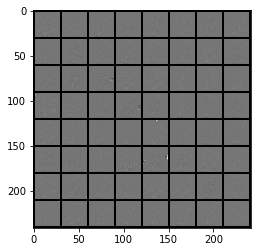

In [51]:
show(torchvision.utils.make_grid(fake))